<a href="https://colab.research.google.com/github/jesusvivo/amd-sm2l/blob/main/AMD_SM2L_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of flight cancellations in the US

First we will retrieve the dataset from Kaggle following the steps at [Easiest way to download kaggle data in Google Colab](https://www.kaggle.com/general/74235)

In [1]:
! pip install -q kaggle

In [2]:
! pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 41 kB/s 
     |████████████████████████████████| 199 kB 44.7 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=cc7e2e4c56b03a43df807259ce0d74d8fee2edde8457b7578bf0d12a2a4425bd
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark


In [3]:
!pip install findspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Now we must upload the Kaggle API token from our machine

In [4]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jesusvivo","key":"56a2f1ecbaabbec6b20715527201ac9d"}'}

In [5]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
! kaggle datasets list

ref                                                             title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
victorsoeiro/netflix-tv-shows-and-movies                        Netflix TV Shows and Movies                           2MB  2022-05-15 00:01:23          12572        371  1.0              
zusmani/petrolgas-prices-worldwide                              Petrol/Gas Prices Worldwide                          10KB  2022-06-24 01:25:33           1152         71  1.0              
devansodariya/student-performance-data                          Student Performance Dataset                           7KB  2022-05-26 13:55:09           7287        209  0.9705882        
ruchi798/data-science-job-salaries                          

In [8]:
!kaggle datasets download -d yuanyuwendymu/airline-delay-and-cancellation-data-2009-2018

100% 1.94G/1.95G [00:17<00:00, 121MB/s]
100% 1.95G/1.95G [00:17<00:00, 116MB/s]


In [9]:
import zipfile
path = 'airline-delay-and-cancellation-data-2009-2018.zip'
folder = 'data'
with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall(folder)

In [10]:
import findspark
findspark.init()

import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder.master('local[1]') \
                    .appName('FinalProject') \
                    .getOrCreate()

df = spark.read.option('header', True) \
     .csv(['data/2018.csv', 'data/2017.csv', 'data/2016.csv', 'data/2015.csv', 'data/2014.csv', \
           'data/2013.csv', 'data/2012.csv', 'data/2011.csv', 'data/2010.csv', 'data/2009.csv'])
df.printSchema()


root
 |-- FL_DATE: string (nullable = true)
 |-- OP_CARRIER: string (nullable = true)
 |-- OP_CARRIER_FL_NUM: string (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- CRS_DEP_TIME: string (nullable = true)
 |-- DEP_TIME: string (nullable = true)
 |-- DEP_DELAY: string (nullable = true)
 |-- TAXI_OUT: string (nullable = true)
 |-- WHEELS_OFF: string (nullable = true)
 |-- WHEELS_ON: string (nullable = true)
 |-- TAXI_IN: string (nullable = true)
 |-- CRS_ARR_TIME: string (nullable = true)
 |-- ARR_TIME: string (nullable = true)
 |-- ARR_DELAY: string (nullable = true)
 |-- CANCELLED: string (nullable = true)
 |-- CANCELLATION_CODE: string (nullable = true)
 |-- DIVERTED: string (nullable = true)
 |-- CRS_ELAPSED_TIME: string (nullable = true)
 |-- ACTUAL_ELAPSED_TIME: string (nullable = true)
 |-- AIR_TIME: string (nullable = true)
 |-- DISTANCE: string (nullable = true)
 |-- CARRIER_DELAY: string (nullable = true)
 |-- WEATHER_DELAY: strin

In [11]:
df.show(5)

+----------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+-----------+
|   FL_DATE|OP_CARRIER|OP_CARRIER_FL_NUM|ORIGIN|DEST|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|CANCELLATION_CODE|DIVERTED|CRS_ELAPSED_TIME|ACTUAL_ELAPSED_TIME|AIR_TIME|DISTANCE|CARRIER_DELAY|WEATHER_DELAY|NAS_DELAY|SECURITY_DELAY|LATE_AIRCRAFT_DELAY|Unnamed: 27|
+----------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+-----------+
|

Since we are only considering information prior to flight departure, we are going to keep only the columns that provide us that information

In [12]:
columns_to_keep = ['FL_DATE', 'OP_CARRIER', 'ORIGIN', 'DEST', 'CRS_DEP_TIME', 'CRS_ARR_TIME', 'CANCELLED', 'CRS_ELAPSED_TIME', 'DISTANCE']

df = df.select(columns_to_keep)

df.show(10)

+----------+----------+------+----+------------+------------+---------+----------------+--------+
|   FL_DATE|OP_CARRIER|ORIGIN|DEST|CRS_DEP_TIME|CRS_ARR_TIME|CANCELLED|CRS_ELAPSED_TIME|DISTANCE|
+----------+----------+------+----+------------+------------+---------+----------------+--------+
|2018-01-01|        UA|   EWR| DEN|        1517|        1745|      0.0|           268.0|  1605.0|
|2018-01-01|        UA|   LAS| SFO|        1115|        1254|      0.0|            99.0|   414.0|
|2018-01-01|        UA|   SNA| DEN|        1335|        1649|      0.0|           134.0|   846.0|
|2018-01-01|        UA|   RSW| ORD|        1546|        1756|      0.0|           190.0|  1120.0|
|2018-01-01|        UA|   ORD| ALB|         630|         922|      0.0|           112.0|   723.0|
|2018-01-01|        UA|   ORD| OMA|        2241|          14|      0.0|            93.0|   416.0|
|2018-01-01|        UA|   IAH| LAS|         750|         916|      0.0|           206.0|  1222.0|
|2018-01-01|        

Let's see the distribution of the classes in our dataset

In [13]:
df.groupBy('CANCELLED').count().show()

+---------+--------+
|CANCELLED|   count|
+---------+--------+
|      1.0|  973209|
|      0.0|60583755|
+---------+--------+



Since we have much more items from the non cancelled class, and we have over 7 million elements, we are going to undersample the majority class in order to balance our dataset

In [14]:
from pyspark.sql.functions import col

def resample(dataframe, column, positive_value):
    positives = dataframe.filter(col(column) == positive_value)
    negatives = dataframe.filter(col(column) != positive_value)
    total_positives = positives.count()
    total_negatives = negatives.count()
    ratio = float(total_positives) / float(total_negatives)
    sampled = negatives.sample(False, ratio)
    return sampled.union(positives)

df = resample(df, 'CANCELLED', '1.0')


In [15]:
df.groupBy('CANCELLED').count().show()

+---------+------+
|CANCELLED| count|
+---------+------+
|      0.0|972165|
|      1.0|973209|
+---------+------+



Now our dataset is balanced. Now we are going to divide the flight date column into two new columns: weekday and month, in order to prepare this variable for the model

In [16]:
from pyspark.sql.functions import dayofweek, month

df = df.withColumn('FL_DATE_WEEKDAY', dayofweek('FL_DATE')).withColumn('FL_DATE_MONTH', month('FL_DATE'))
df = df.drop(df.FL_DATE)
df.show(10)

+----------+------+----+------------+------------+---------+----------------+--------+---------------+-------------+
|OP_CARRIER|ORIGIN|DEST|CRS_DEP_TIME|CRS_ARR_TIME|CANCELLED|CRS_ELAPSED_TIME|DISTANCE|FL_DATE_WEEKDAY|FL_DATE_MONTH|
+----------+------+----+------------+------------+---------+----------------+--------+---------------+-------------+
|        UA|   DEN| IAH|        1900|        2219|      0.0|           139.0|   862.0|              2|            1|
|        UA|   TPA| EWR|         745|        1025|      0.0|           160.0|   997.0|              2|            1|
|        UA|   IAH| EWR|        2005|          30|      0.0|           205.0|  1400.0|              2|            1|
|        UA|   LIH| SFO|        2210|         518|      0.0|           308.0|  2447.0|              2|            1|
|        UA|   SNA| ORD|         655|        1306|      0.0|           251.0|  1726.0|              2|            1|
|        UA|   ORD| EWR|        1035|        1345|      0.0|    

Our next step will be turning the column OP_CARRIER, which is the airline of the flight, into a numerical column, called AIRLINE_ID

In [17]:
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol = 'OP_CARRIER', outputCol = 'AIRLINE_ID') 
df = indexer.fit(df).transform(df) 
df = df.drop(df.OP_CARRIER)

df.show(10)

+------+----+------------+------------+---------+----------------+--------+---------------+-------------+----------+
|ORIGIN|DEST|CRS_DEP_TIME|CRS_ARR_TIME|CANCELLED|CRS_ELAPSED_TIME|DISTANCE|FL_DATE_WEEKDAY|FL_DATE_MONTH|AIRLINE_ID|
+------+----+------------+------------+---------+----------------+--------+---------------+-------------+----------+
|   DEN| IAH|        1900|        2219|      0.0|           139.0|   862.0|              2|            1|       6.0|
|   TPA| EWR|         745|        1025|      0.0|           160.0|   997.0|              2|            1|       6.0|
|   IAH| EWR|        2005|          30|      0.0|           205.0|  1400.0|              2|            1|       6.0|
|   LIH| SFO|        2210|         518|      0.0|           308.0|  2447.0|              2|            1|       6.0|
|   SNA| ORD|         655|        1306|      0.0|           251.0|  1726.0|              2|            1|       6.0|
|   ORD| EWR|        1035|        1345|      0.0|           130.

Let's do the same now for the ORIGIN and DEST columns

In [18]:
indexer = StringIndexer(inputCol = 'ORIGIN', outputCol = 'ORIGIN_ID', stringOrderType = 'alphabetDesc') 
df = indexer.fit(df).transform(df) 
df = df.drop(df.ORIGIN)

indexer = StringIndexer(inputCol = 'DEST', outputCol = 'DEST_ID', stringOrderType = 'alphabetDesc') 
df = indexer.fit(df).transform(df) 
df = df.drop(df.DEST)

df.show(10)

+------------+------------+---------+----------------+--------+---------------+-------------+----------+---------+-------+
|CRS_DEP_TIME|CRS_ARR_TIME|CANCELLED|CRS_ELAPSED_TIME|DISTANCE|FL_DATE_WEEKDAY|FL_DATE_MONTH|AIRLINE_ID|ORIGIN_ID|DEST_ID|
+------------+------------+---------+----------------+--------+---------------+-------------+----------+---------+-------+
|        1900|        2219|      0.0|           139.0|   862.0|              2|            1|       6.0|    278.0|  205.0|
|         745|        1025|      0.0|           160.0|   997.0|              2|            1|       6.0|     21.0|  256.0|
|        2005|          30|      0.0|           205.0|  1400.0|              2|            1|       6.0|    204.0|  256.0|
|        2210|         518|      0.0|           308.0|  2447.0|              2|            1|       6.0|    165.0|   52.0|
|         655|        1306|      0.0|           251.0|  1726.0|              2|            1|       6.0|     39.0|  115.0|
|        1035|  

Finally, we are going to drop the CRS_ARR_TIME and DISTANCE columns, since they have a strong correlation with the CRS_DEP_TIME and CRS_ELAPSED_TIME columns, respectively. We are going to keep the latter ones because their values are lower and have less variance.

In [19]:
df = df.drop('CRS_ARR_TIME', 'DISTANCE')
df.show(10)

+------------+---------+----------------+---------------+-------------+----------+---------+-------+
|CRS_DEP_TIME|CANCELLED|CRS_ELAPSED_TIME|FL_DATE_WEEKDAY|FL_DATE_MONTH|AIRLINE_ID|ORIGIN_ID|DEST_ID|
+------------+---------+----------------+---------------+-------------+----------+---------+-------+
|        1900|      0.0|           139.0|              2|            1|       6.0|    278.0|  205.0|
|         745|      0.0|           160.0|              2|            1|       6.0|     21.0|  256.0|
|        2005|      0.0|           205.0|              2|            1|       6.0|    204.0|  256.0|
|        2210|      0.0|           308.0|              2|            1|       6.0|    165.0|   52.0|
|         655|      0.0|           251.0|              2|            1|       6.0|     39.0|  115.0|
|        1035|      0.0|           130.0|              2|            1|       6.0|    114.0|  256.0|
|        1900|      0.0|           348.0|              2|            1|       6.0|    278.0

As last steps of cleaning and preparing the datasets, we will select the final list of features for our model in order to normalize them and remove any that has some missing value

In [20]:
cols_to_normalize = ['CRS_DEP_TIME', 'CRS_ELAPSED_TIME', 'FL_DATE_WEEKDAY','FL_DATE_MONTH','AIRLINE_ID', 'ORIGIN_ID','DEST_ID']

df = df.dropna(how = 'any')

In [21]:
df.printSchema()

root
 |-- CRS_DEP_TIME: string (nullable = true)
 |-- CANCELLED: string (nullable = true)
 |-- CRS_ELAPSED_TIME: string (nullable = true)
 |-- FL_DATE_WEEKDAY: integer (nullable = true)
 |-- FL_DATE_MONTH: integer (nullable = true)
 |-- AIRLINE_ID: double (nullable = false)
 |-- ORIGIN_ID: double (nullable = false)
 |-- DEST_ID: double (nullable = false)



We are going to transform the columns that are strings into integers in order to build the vector of features correctly

In [22]:
df = df.withColumn('CRS_DEP_TIME', df.CRS_DEP_TIME.cast('int')) \
        .withColumn('CANCELLED', df.CANCELLED.cast('int')) \
        .withColumn('CRS_ELAPSED_TIME', df.CRS_ELAPSED_TIME.cast('int'))

In [23]:
df.printSchema()

root
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- CANCELLED: integer (nullable = true)
 |-- CRS_ELAPSED_TIME: integer (nullable = true)
 |-- FL_DATE_WEEKDAY: integer (nullable = true)
 |-- FL_DATE_MONTH: integer (nullable = true)
 |-- AIRLINE_ID: double (nullable = false)
 |-- ORIGIN_ID: double (nullable = false)
 |-- DEST_ID: double (nullable = false)



Adding a new column with the vectorized features

In [24]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler().setInputCols(cols_to_normalize).setOutputCol('vectorized_features')
df = assembler.transform(df)
df.show(10)

+------------+---------+----------------+---------------+-------------+----------+---------+-------+--------------------+
|CRS_DEP_TIME|CANCELLED|CRS_ELAPSED_TIME|FL_DATE_WEEKDAY|FL_DATE_MONTH|AIRLINE_ID|ORIGIN_ID|DEST_ID| vectorized_features|
+------------+---------+----------------+---------------+-------------+----------+---------+-------+--------------------+
|        1900|        0|             139|              2|            1|       6.0|    278.0|  205.0|[1900.0,139.0,2.0...|
|         745|        0|             160|              2|            1|       6.0|     21.0|  256.0|[745.0,160.0,2.0,...|
|        2005|        0|             205|              2|            1|       6.0|    204.0|  256.0|[2005.0,205.0,2.0...|
|        2210|        0|             308|              2|            1|       6.0|    165.0|   52.0|[2210.0,308.0,2.0...|
|         655|        0|             251|              2|            1|       6.0|     39.0|  115.0|[655.0,251.0,2.0,...|
|        1035|        0|

Normalizing the features vector and getting the final vector that will be the input for our model

In [25]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler().setInputCol('vectorized_features').setOutputCol('features')
df = scaler.fit(df).transform(df)
df.show(10)

+------------+---------+----------------+---------------+-------------+----------+---------+-------+--------------------+--------------------+
|CRS_DEP_TIME|CANCELLED|CRS_ELAPSED_TIME|FL_DATE_WEEKDAY|FL_DATE_MONTH|AIRLINE_ID|ORIGIN_ID|DEST_ID| vectorized_features|            features|
+------------+---------+----------------+---------------+-------------+----------+---------+-------+--------------------+--------------------+
|        1900|        0|             139|              2|            1|       6.0|    278.0|  205.0|[1900.0,139.0,2.0...|[3.96645704679298...|
|         745|        0|             160|              2|            1|       6.0|     21.0|  256.0|[745.0,160.0,2.0,...|[1.55526868413725...|
|        2005|        0|             205|              2|            1|       6.0|    204.0|  256.0|[2005.0,205.0,2.0...|[4.18565598885260...|
|        2210|        0|             308|              2|            1|       6.0|    165.0|   52.0|[2210.0,308.0,2.0...|[4.61361582811184...|

Our dataset is ready to be trained. Let's split it and build our model with it. We will convert our PySpark Dataframes to NumPy arrays, in order to perform the mathematical operations with them

In [26]:
train, test = df.randomSplit([0.8, 0.2])

In [27]:
import numpy as np

X_train = np.array(train.select('features').collect())
X_train = np.reshape(X_train, (len(X_train), len(X_train[0][0])))

X_test = np.array(test.select('features').collect())
X_test = np.reshape(X_test, (len(X_test), len(X_test[0][0])))

y_train = np.array(train.select('CANCELLED').collect())
y_train = np.reshape(y_train, (len(y_train),))

y_test = np.array(test.select('CANCELLED').collect())
y_test = np.reshape(y_test, (len(y_test),))

In [28]:
class LogisticRegression:
    def __init__(self, learning_rate = 0.01, n_iterations = 1000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def fit(self, X, y):        
        M, N = X.shape

        # First we initialize the weights vector, which has a size equal to 
        # the number of features, with zeros
        # We also set the initial bias parameter to 0

        self.weights = np.zeros(N)
        self.bias = 0

        # We initiate now the learning loop

        for i in range(self.n_iterations):
            # Calculate the prediction applying the y = w · x + b linear function.
            # Then apply the sigmoid function to the linear prediction
            # so that it returns a value between 0 and 1.

            Z = np.dot(X, self.weights) + self.bias
            y_predicted = self.sigmoid(Z)

            # We now compute the cost using the log loss function, 
            # in order to test different hyperparameter settings
            cost = - (1 / M) * np.sum(y * np.log(y_predicted) + (1 - y) *  np.log(1 - y_predicted))

            if i % 100 == 0:
              print(i, 'th iteration, log loss:', cost)

            # Apply gradient descent to optimize weights and bias and update them
            dW = (1 / M) * np.dot(X.T, (y_predicted - y))
            dB = (1 / M) * np.sum(y_predicted - y)

            self.weights = self.weights - self.learning_rate * dW
            self.bias = self.bias - self.learning_rate * dB

    def predict(self, X):
        Z = np.dot(X, self.weights) + self.bias
        y_predicted = self.sigmoid(Z)

        y_predicted = [1 if i > 0.5 else 0 for i in y_predicted]

        return np.array(y_predicted)

In [29]:
model = LogisticRegression(learning_rate = 0.2, n_iterations = 1000)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

0 th iteration, log loss: 0.6931471805599465
100 th iteration, log loss: 0.6773129105907442
200 th iteration, log loss: 0.677034830510787
300 th iteration, log loss: 0.6768337474611303
400 th iteration, log loss: 0.6766878815257485
500 th iteration, log loss: 0.6765820437360683
600 th iteration, log loss: 0.6765052307402757
700 th iteration, log loss: 0.6764494697427694
800 th iteration, log loss: 0.6764089822492722
900 th iteration, log loss: 0.6763795788615198


Let's see the metrics for our model:

In [30]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.58      0.55      0.57    194899
           1       0.57      0.60      0.58    194411

    accuracy                           0.57    389310
   macro avg       0.58      0.57      0.57    389310
weighted avg       0.58      0.57      0.57    389310



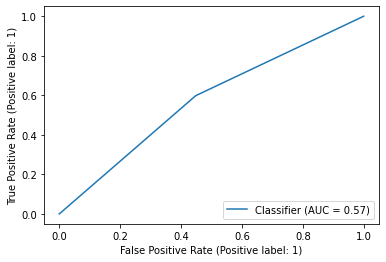

In [31]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(y_test, predictions)

Our model isn't great, but now let's compare our model with the Logistic Regression implementation in the MLlib library from PySpark: 

In [32]:
from pyspark.ml.classification import LogisticRegression

model2 = LogisticRegression(featuresCol = 'features', labelCol = 'CANCELLED', maxIter = 1000)
model2 = model2.fit(train)

In [33]:
predictions_model2 = model2.transform(test)

In [34]:
y_true2 = predictions_model2.select("CANCELLED")
y_true2 = y_true2.toPandas()

y_pred2 = predictions_model2.select("prediction")
y_pred2 = y_pred2.toPandas()

In [35]:
print(classification_report(y_true2, y_pred2))

              precision    recall  f1-score   support

           0       0.58      0.55      0.56    194899
           1       0.57      0.60      0.59    194411

    accuracy                           0.57    389310
   macro avg       0.57      0.57      0.57    389310
weighted avg       0.57      0.57      0.57    389310



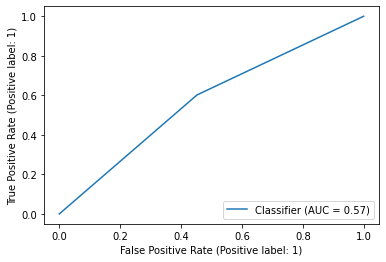

In [45]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(y_true2, np.array(predictions_model2.select('prediction').collect()))

Comparing both models, the metrics are almost identical. We can say that our implementation is fine.